In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


sklearn version:  1.0.2
TF version:  2.8.0
GPU installed:  True
4 Physical GPUs, 4 Logical GPUs


2022-06-15 14:40:25.638171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 14:40:28.958447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14786 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2022-06-15 14:40:28.962896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14786 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-06-15 14:40:28.964711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

In [22]:
#황성현 
class Inveted_Residual_Block2(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        initializer = tf.keras.initializers.HeNormal()
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, kernel_initializer=initializer,
                                padding="SAME"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME",kernel_initializer=initializer),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME",kernel_initializer=initializer),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,kernel_initializer=initializer,
                                padding="SAME"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",kernel_initializer=initializer),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",kernel_initializer=initializer),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [9]:
#황성현
class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME",activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [42]:
#작성자 전민재
import numpy as np
import csv

#contest csv파일명 바꿔!
csv_data_file = open("./emnist-byclass-test.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 



f = csv.reader(csv_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)

X_contest=[]
y_contest=[]


for i, row in enumerate(f):
    #행마다 int로 형변환
    for idx, char in enumerate(row):
        row[idx]=int(char)
    #train
    #data 추가    
    X_contest.append(np.uint8(row[1:]))
    y_contest.append(np.float32(row[0]))

#데이터셋의 transpose 대비
def rotate_90(m):
    N = len(m)
    ret = [[0] * N for _ in range(N)]
    
    for r in range(N):
        for c in range(N):
            ret[c][N-1-r] = m[r][c]
    return np.array(ret)

def vreflect(m):
    N = len(m)
    ret = [[0] * N for _ in range(N)]
    
    for r in range(N):
        for c in range(N):
            ret[r][c] = m[r][N-1-c]
    return np.array(ret)


#contest set 
X_contest=np.array(X_contest)
y_contest=np.array(y_contest)
X_contest=X_contest.reshape(-1,28,28)

#만약 data set들이 transpose 되어있다면 사용하자
#회전
#for idx,i in enumerate(X_contest):
#    X_contest[idx]=rotate_90(i)
#상하반전
#for idx,i in enumerate(X_contest):
#    X_contest[idx]=vreflect(i)

X_contest=tf.reshape(X_contest,[-1,28,28,1])
X_contest_resize=np.uint8(tf.image.resize(X_contest, [32, 32]))
X_contest_final=keras.applications.mobilenet_v2.preprocess_input(np.array(X_contest_resize,np.float32))






In [43]:
X_contest.shape,X_contest.dtype,y_contest.shape,y_contest.dtype

(TensorShape([116323, 28, 28, 1]), tf.uint8, (116323,), dtype('float32'))

In [44]:
#모델 이름 바꾸기!
best_model=keras.models.load_model("smv2l_adam_lrsch_onecycle001_aug_dropout_128_he_irb6_512_noact.h5",
                             custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block2})
best_model.evaluate(X_contest_final,y_contest)

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)
3636/3636 [==============================] - 42s 12ms/step - loss: 0.3187 - accuracy: 0.8796


[0.3186958134174347, 0.8795766830444336]

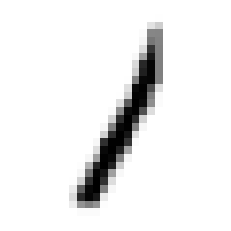

In [46]:
import matplotlib.pyplot as plt

c=X_contest[0]


plt.imshow(c, cmap="binary")
plt.axis('off')
plt.show()

